# Model Images Clustering
For each product image, select 1 model image, which is closest to a full-body image front-facing.

In [8]:
import os
import glob
from shutil import copyfile
import pandas as pd
import numpy as np
import random

from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import cv2

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.externals import joblib

import sys
sys.path.append("../")
from src import image_utils

%matplotlib inline

## Load images

In [10]:
# read data
filelist = glob.glob('../data/images/fashion_models/dresses/*.jpg')
filelist = sorted(filelist)
print('num images: ', len(filelist))

num images:  15304


# Get Feature Vectors

In [31]:
def get_edges_for_img(img_path, img_size, crop=False):
    img = Image.open(img_path)
    if crop:
        w, h = img.size
        img = img.crop((70, 0, w-70, h))
    img = img.resize(img_size, Image.ANTIALIAS)
    img = img.filter(ImageFilter.FIND_EDGES)
    img = img.convert('L')
    img_arr = np.array(img)
    img.close()
    
    return(img_arr)

In [4]:
def get_outline_for_img(img_path, img_size, crop=False):
    outline = get_outline(img_path, crop)
    img = Image.fromarray(outline)
    img = img.resize(img_size)
    img_arr = np.array(img)
    img.close()
    
    return(img_arr)

In [5]:
def get_outline(img_path, crop=False, threshold=200):
    # Read image
    im_in = cv2.imread(img_path)
    if crop:
        im_in = im_in[0:256, 70:186]
    im_in = cv2.cvtColor(im_in, cv2.COLOR_BGR2GRAY)

    im_in = cv2.GaussianBlur(im_in, (5, 5), 0)
    ret, thresh = cv2.threshold(im_in, threshold, 255, cv2.THRESH_BINARY)
    newimg = cv2.bitwise_not(thresh)

    im2, contours, hierarchy = cv2.findContours(newimg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        cv2.drawContours(newimg, [cnt], 0, 255, -1)

#     edged = cv2.bitwise_not(cv2.Canny(newimg, 0, 255))
    
    smooth = cv2.GaussianBlur(newimg, (9, 9), 0)
    _, thresh2 = cv2.threshold(smooth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((2, 2), np.uint8)
    erosion2 = cv2.dilate(thresh2, kernel, iterations=1)

    return erosion2

In [6]:
def get_edges(file_list, img_size, smooth=False, cropped=False, print_progress=False):
    imgs = []
    
    get_edges_fun = get_outline_for_img if smooth else get_edges_for_img
    
    for idx, img_path in enumerate(file_list):
        if (idx % 5000 == 0) & print_progress:
            print(idx)
        
        imgs.append(get_edges_fun(img_path, img_size, crop=cropped))
        
    X = np.array([img for img in imgs])
    return(X)

In [ ]:
def get_features()

In [2]:
img_size = [64, 64]

In [ ]:
outlines = get_edges(filelist, img_size, smooth=True, cropped=True, print_progress=True)
np.save('./clustering/features_outlines.npy', outlines)

In [4]:
edges = np.load('./data/clustering/features_edges.npy')
edges_crop = np.load('./data/clustering/features_edges_crop.npy')
outlines = np.load('./data/clustering/features_outlines.npy')

In [9]:
print(edges.shape)
print(edges_crop.shape)
print(outlines.shape)

(63103, 64, 64)
(63103, 64, 64)
(63103, 64, 64)


In [16]:
edges[5].shape

(64, 64)

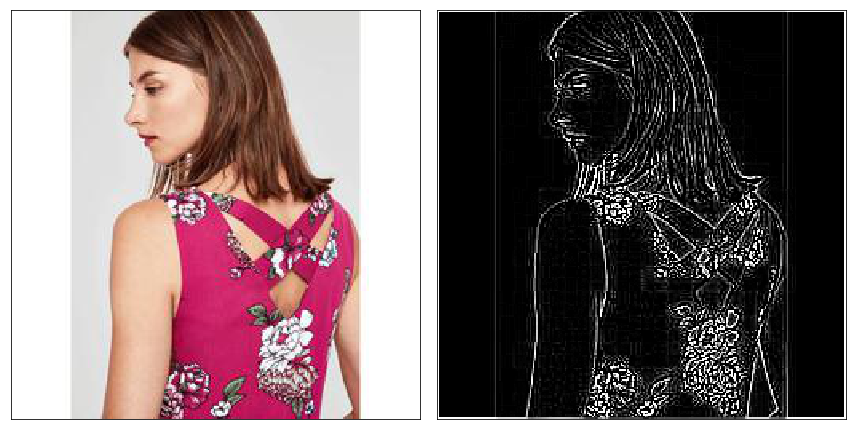

In [47]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 9))
axarr[0].imshow(Image.open(filelist[7]))
axarr[1].imshow(get_edges_for_img(filelist[7], img_size=[256, 256]), cmap='gray')

for ax in axarr:
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()

# Cluster
Find clusters - usually whole model image, zoomed model image and detail images

In [ ]:
X = outlines.reshape([outlines.shape[0], np.prod(outlines.shape[1:])])
X.shape

In [ ]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)
joblib.dump(kmeans, './clustering/kmeans_outlines_4.pkl') 

##  Visualize Clusters

In [10]:
def plot_images_by_cluster(df_cluster, num_imgs, plot_center=False, cluster_centers=None):
    n_clusters = df_cluster.cluster.nunique()        
    imgs = df_cluster.groupby('cluster').agg({'path': 'unique'})
    random.seed(42)
    
    ncols = num_imgs+1 if plot_center else num_imgs
    fig, axarr = plt.subplots(nrows=n_clusters, ncols=ncols, figsize=(2*num_imgs, 2*n_clusters))
    
    for cluster in imgs.index:
        cluster_imgs = imgs.loc[cluster, 'path'].tolist()
        print('Cluster {}: {} images'.format(cluster, len(cluster_imgs)))
        cluster_imgs = random.sample(cluster_imgs, num_imgs)
        
        plt_idx = 0
        if plot_center:
            ax = axarr[cluster][plt_idx]
            ax.axis('off')
            center = np.array(cluster_centers)[cluster]
            img = Image.fromarray(center.reshape(img_size))
            ax.imshow(img)
            plt_idx = 1
        
        for img_path in cluster_imgs:
            ax = axarr[cluster][plt_idx]
            ax.axis('off')
            img = Image.open(img_path)
            ax.imshow(img)
            plt_idx += 1
            
    plt.show()

In [11]:
def plot_cluster_centers(centers):
    
    fig=plt.figure(figsize=(8, 8))
    
    for idx, center in enumerate(centers):
        ax = fig.add_subplot(4, 4, idx+1)
        ax.axis('off')
        center = center.reshape(img_size)
        img = Image.fromarray(center)
        plt.imshow(img)
    plt.show()

In [12]:
def load_kmeans_model(path):
    kmeans = joblib.load(path)
    clusters = kmeans.labels_.tolist()
    centers = np.array(kmeans.cluster_centers_)
    
    return clusters, centers

In [13]:
kmeans2_clusters, kmeans2_centers = load_kmeans_model('./clustering/kmeans_edges_2.pkl')
kmeans3_clusters, kmeans3_centers = load_kmeans_model('./clustering/kmeans_edges_3.pkl')
kmeans4_clusters, kmeans4_centers = load_kmeans_model('./clustering/kmeans_edges_4.pkl')
outline_clusters, outline_centers = load_kmeans_model('./clustering/kmeans_outlines_4.pkl')
outline3_clusters, outline3_centers = load_kmeans_model('./clustering/outlines_3.pkl')

# Amount of images by clusters

In [ ]:
df2 = pd.DataFrame(list(zip(kmeans2_clusters, filelist)), columns=['cluster', 'path'])
df2.groupby('cluster').count()

In [ ]:
df3 = pd.DataFrame(list(zip(kmeans3_clusters, filelist)), columns=['cluster', 'path'])
df3.groupby('cluster').count()

In [ ]:
df4 = pd.DataFrame(list(zip(kmeans4_clusters, filelist)), columns=['cluster', 'path'])
df4.groupby('cluster').count()

In [ ]:
df4o = pd.DataFrame(list(zip(outline_clusters, filelist)), columns=['cluster', 'path'])
df4o.groupby('cluster').count()

In [14]:
df3o = pd.DataFrame(list(zip(outline3_clusters, filelist)), columns=['cluster', 'path'])
df3o.groupby('cluster').count()

,path
cluster,
0,26832
1,17899
2,18372


## Cluster centers

In [ ]:
plot_cluster_centers(kmeans2_centers)

In [ ]:
plot_cluster_centers(kmeans3_centers)

In [ ]:
plot_cluster_centers(kmeans4_centers)

In [ ]:
plot_cluster_centers(outline_centers)

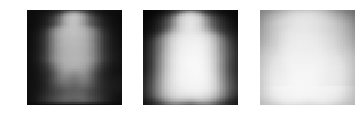

In [15]:
plot_cluster_centers(outline3_centers)

## Plot random sample of images

In [ ]:
plot_images_by_cluster(df2, 8, plot_center=True, cluster_centers=kmeans2_centers)

In [ ]:
plot_images_by_cluster(df3, 8, plot_center=True, cluster_centers=kmeans3_centers)

In [ ]:
plot_images_by_cluster(df4, 8, plot_center=True, cluster_centers=kmeans4_centers)

In [ ]:
plot_images_by_cluster(df4o, 8, plot_center=True, cluster_centers=outline_centers)

Cluster 0: 26832 images
Cluster 1: 17899 images
Cluster 2: 18372 images


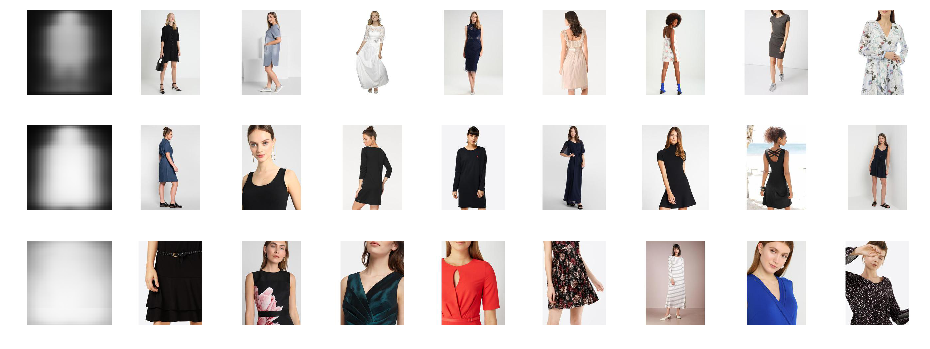

In [16]:
plot_images_by_cluster(df3o, 8, plot_center=True, cluster_centers=outline3_centers)

## Select image for each product

In [17]:
def get_id_from_img_path(img_path):
    return os.path.basename(img_path).split('@')[0]

In [18]:
def get_product_id_file_idxs(product_id, filelist):
    return [idx for idx, f in enumerate(filelist) if get_id_from_img_path(f) == product_id]

In [19]:
def get_product_files_and_features(product_id, filelist, features):
    product_idxs = get_product_id_file_idxs(product_id, filelist)
    product_files = np.array(filelist)[product_idxs]
    product_feats = reshape_features(features[product_idxs])
    
    return product_files, product_feats

In [20]:
def reshape_features(features):
    return features.reshape(features.shape[0], np.prod(features.shape[1:]))

In [21]:
def plot_best_images_by_clusters(cluster_centers, product_ids, filelist, features, plot_centers=True):
    n_centers = len(cluster_centers)
    n_products = (len(product_ids) + 1) if plot_centers else len(product_ids)
    
    fig, axarr = plt.subplots(nrows=n_centers, ncols=n_products,
                              figsize=((n_products)*2, (n_centers)*2))
    
    if plot_centers:
        for cen_idx, center in enumerate(cluster_centers):
            ax = axarr[cen_idx][0]
            ax.imshow(Image.fromarray(center.reshape([64, 64])).resize([216, 256]))
            ax.axis('off')
    
    for idx, product_id in enumerate(product_ids):
        product_files, product_feats = get_product_files_and_features(product_id, filelist, features)
    
        dist = pairwise_distances(product_feats, cluster_centers)
        imgs_idxs = dist.argmin(0)
        best_imgs = product_files[imgs_idxs]
        
        for img_idx, img in enumerate(best_imgs):
            ax = axarr[img_idx][idx+1]
            ax.axis('off')
            ax.imshow(Image.open(img))
    
    plt.tight_layout()
    plt.show()


In [130]:
def plot_product_imgs(product_id, best_center, features, filelist):
    product_files, product_feats = get_product_files_and_features(product_id, filelist, features)
    
    dist = pairwise_distances(product_feats, best_center.reshape(1, -1))[:, 0]
    sort_args = np.argsort(dist)
    product_files = np.array(product_files)[sort_args]
    dist = np.array(dist)[sort_args]
    
    n_products = len(product_files) + 1
    fig, axarr = plt.subplots(nrows=1, ncols=n_products, figsize=(n_products*2, 2))
    
    ax = axarr[0]
    ax.imshow(Image.fromarray(best_center.reshape([64, 64])).resize([216, 256]))
    ax.axis('off')
    
    for idx, product_file in enumerate(product_files):  
        ax = axarr[idx+1]
        img = Image.open(product_file)
        ax.set_xlabel(round(dist[idx], 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
        for s in ax.spines.keys():
            ax.spines[s].set_visible(False)
        ax.imshow(img)
    
    plt.show()

In [23]:
product_ids = list(set([get_id_from_img_path(f) for f in filelist]))

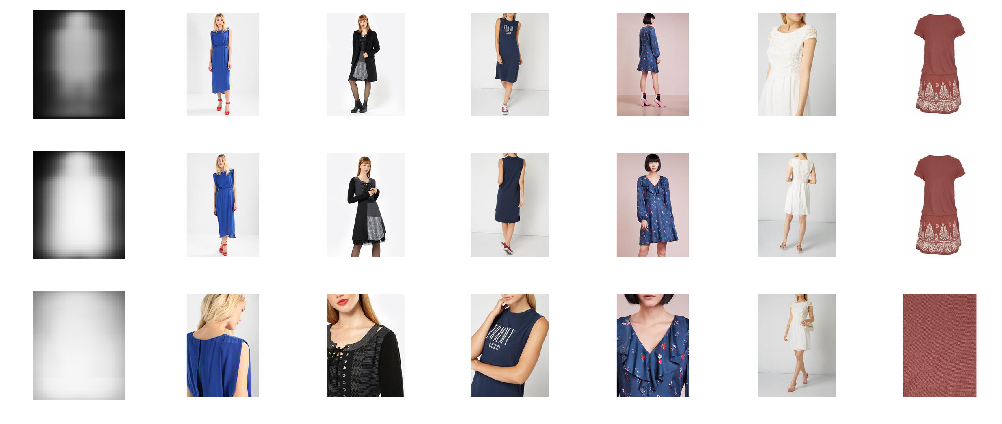

In [128]:
test_ids = [1510, 1511, 1513, 1515, 1512, 1502]

s = np.array(product_ids)[test_ids] 
plot_best_images_by_clusters(outline3_centers, s, filelist, outlines)

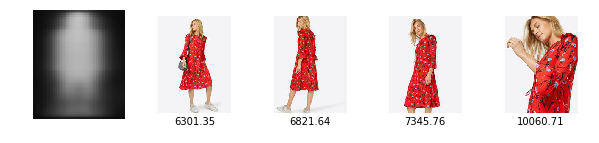

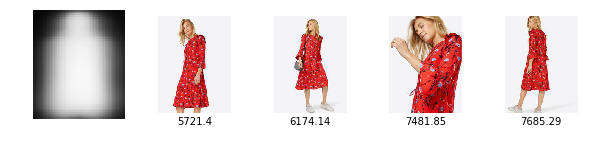

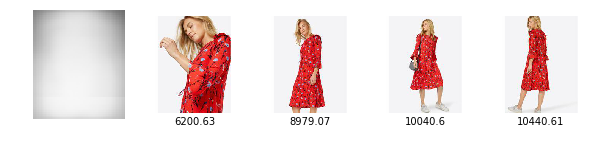

In [144]:
for c in outline3_centers:
    plot_product_imgs(product_ids[8], c, outlines, filelist)

# Test Number of Cluster Centers

In [ ]:
X = outlines.reshape([outlines.shape[0], np.prod(outlines.shape[1:])])
X.shape

for num_clusters in range(8, 9):
    print(num_clusters)
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X)
    joblib.dump(kmeans, './clustering/outlines_{}.pkl'.format(num_clusters)) 

In [ ]:
d = []
for num_clusters in range(2, 8):
    kmeans = joblib.load('./clustering/outlines_{}.pkl'.format(num_clusters)) 
    d.append(kmeans.inertia_ / len(X)) 

In [ ]:
plt.plot(d)

In [ ]:
k_clusters = []
k_centers = []
for num_clusters in range(2, 8):
    cl, cnt = load_kmeans_model('./clustering/outlines_{}.pkl'.format(num_clusters))
    k_clusters.append(cl)
    k_centers.append(cnt)

In [ ]:
for centers in k_centers:
    plot_cluster_centers(centers)

In [ ]:
for centers, clusters in zip(k_centers, k_clusters):
    df = pd.DataFrame(list(zip(clusters, filelist)), columns=['cluster', 'path'])
    plot_images_by_cluster(df, 8, plot_center=True, cluster_centers=centers)

# Save Clustered Images

In [ ]:
save_dir = '../../data/fashion_models/dresses_clustered2/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
def get_best_image_for_cluster(img_features, cluster_center):
    
    img_features = img_features.reshape(img_features.shape[0], 
                                        np.prod(img_features.shape[1:]))
    dist = pairwise_distances(img_features, cluster_center.reshape(1, -1))
    best_img_idx = dist.argmin()
    
    return best_img_idx

In [ ]:
best_cluster_center = outline3_centers[0]

for idx, product_id in enumerate(product_ids):
    if idx % 100 == 0:
        print('Clustered: {} / {}'.format(idx, len(product_ids)))

    product_files = [f for f in filelist if get_id_from_img_path(f) == product_id]
    edges = get_edges(product_files, img_size, smooth=True, cropped=True)
    img_idx = get_best_image_for_cluster(edges, best_cluster_center)
    
    src_path = product_files[img_idx]
    dst_path = os.path.join(save_dir, product_id + '.jpg')
    
    if not os.path.exists(dst_path):
        copyfile(src_path, dst_path)

In [ ]:
# Check image that wre deleted manually, if htey have a better picture

best_cluster_center = outline3_centers[0]

for idx, product_id in enumerate(product_ids):
    
    dst_path = os.path.join(save_dir, product_id + '.jpg')
    
    if not os.path.exists(dst_path):

        product_files = [f for f in filelist if get_id_from_img_path(f) == product_id]
        edges = get_edges(product_files, img_size, smooth=True, cropped=True)
        img_idx = get_best_image_for_cluster(edges, best_cluster_center)

        src_path = product_files[img_idx]
        
        if len(product_files) > 1:
            fig, axarr = plt.subplots(1, len(product_files)+1, figsize=((len(product_files)+1)*2, 2))

            ax = axarr[0]
            ax.imshow(Image.open(src_path))
            ax.set_title(product_id)
            ax.set_xticks([])
            ax.set_yticks([])
            
            for i, img in enumerate(product_files):
                ax = axarr[i+1]
                ax.imshow(Image.open(img))
                ax.axis('off')

            plt.show()